# Notas reunión Jesús  

1.- Afinidad He: tiene valores negativos la raíz

Gauss:  distancia eucídea  
l1: distancia l1. suma de los valores absolutos  
He: distancia euclídea de la raíz de las componentes (ignorar)  

convierte la distancia ne similitud

th_gauss: similitud que me sale como mínimo    

distancia emd_distance (WMD en embeddings)  

pyemd (libreria) 

gensim(?)  
coste = 1-S  
minimiza o maximiza? admite costes negativos?  matrices sparse?  


Por qué se traspone Kw?   
$S = F @ (Kw.T)^n @ F.T$

In [9]:
from gensim.models import KeyedVectors
import gensim
from gensim.test.utils import common_texts

import os
import subprocess

import wikipediaapi

from time import monotonic as timer

import pandas as pd

import numpy as np


from nltk import download
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import sys

from pprint import pprint

pd.options.display.max_columns = None

from scipy import sparse


from sim_graph0 import *

# Load the embeddings

In [2]:
wv = KeyedVectors.load('./TSC_Corpus1')

In [3]:
tokens = list(wv.vocab.keys())
print("Number of tokens on this corpus:", len(tokens))
print("The first n tokens are ", tokens[0:4])

Number of tokens on this corpus: 4404
The first n tokens are  ['abel', 'abstract', 'abstraction', 'abstractness']


# Create a pandas dataframe containing word embeddings...  

~~and normalize each token so all the rows sum up to 1~~

In [6]:
data = {'token': tokens}
for n in range(wv.vector_size):
    data[n] = [wv[token][n] for token in tokens]
    
df = pd.DataFrame(data = data)


# Normalize
mat_a = np.matrix(df.iloc[:, 1:])
# mat_a /= mat_a.sum(axis=1)

# df.iloc[:, 1:] = mat_a
# print(df.sum(axis = 1))

print(df.shape)

(4404, 301)


# Get the embedding matrix (drop the token column)

In [7]:
matrix = df.drop(columns = 'token').values

# Compute the similarity matrix: $K_w$  

taking in account that $K_w$ is an sparse matrix (i.e, it's represented as a list of non-zero values).  

For that purpose, several similarity functions can be used. At this moment, _Gauss_ (i.e Euclidean distance) and _L1_ distances are available.  
Improving the overall computing time, a distance threshold is used (_R_). This threshold allows us to set to 0 all the tokens (points) which distance (computed using the mentioned methods) is bigger than R.   
The bigger the R, the denser $K_w$ will be (i.e, more non-zero values).

In [8]:
sim = SimGraph(matrix)

similarity_list = ['l1', 'Gauss']
similarity = similarity_list[1]


th_gauss = 0.2
R = 3
sim.computeGraph(R=R,  similarity=similarity, th_gauss=th_gauss)

In [10]:
affinity_Kw = np.array(sim.affinityT)
edge_Kw = np.array(sim.edgeT_id)

print("Number of non-zero values: ", len(affinity_Kw))

Number of non-zero values:  8468


on this case, $K_w$ is refered as a combination of coordinates (_edgeKw_) and the actual value of each position (affinity_Kw).  
So, we can rewrite those vectors (using matricial notation):  

$$  
edge\_K_w = [p_1, p_2, \dots, p_n]^T
$$

where the value of each point (i.e $p_i$) is given by the _affinity _Kw_ vector:
$$  
affinity\_K_w = [a_1, a_2, \dots, a_n]^T
$$

# Get the dense matrix from the given vectors (it may be necessary)

In [40]:
Kw = np.zeros([len(tokens), len(tokens)])
Kw[edge_Kw[:, 0], edge_Kw[:, 1]] = affinity_Kw

Kw = sparse.coo_matrix(Kw)Areas of mathematics


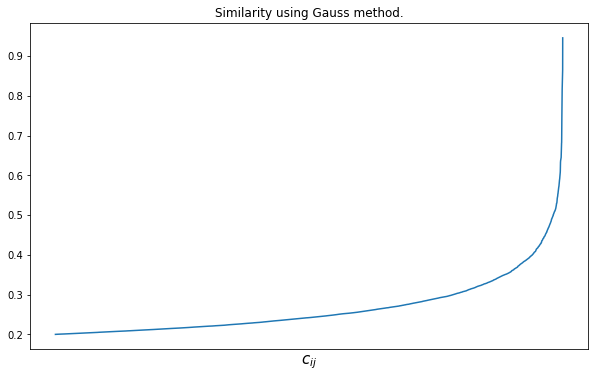

In [42]:
import matplotlib.pyplot as plt 
plt.figure(figsize = [10, 6])
plt.plot(np.sort(affinity_Kw));
plt.xticks([]); plt.xlabel('$c_{ij}$', size = 15); plt.ylabel('', size = 15); plt.title('Similarity using ' + similarity +" method.");

In [171]:
# Create an instance
wiki_wiki = wikipediaapi.Wikipedia('en')

categories = ['Mathematics', 'Economics', 'Philosophy', 'Art']

target = ['Areas of mathematics', 'Wall Street']

categories += target

docs = []

# Include the category definition as a list
for cat in categories:
    print("Getting definition of ", cat)
    docs.append({cat: wiki_wiki.page(cat).text})

print("Number of Documents: ", len(docs))

wnl = WordNetLemmatizer()
stopwords_en = stopwords.words('english')

corpus_clean = []

for doc in docs:
    for val in doc.values():
#         print("Tokenizing", list(doc.keys())[0])
        # Tokenize each text entry. 
        tokens_aux = word_tokenize(val)
        tokens_filtered = [el.lower() for el in tokens_aux if el.isalnum()]
        tokens_lemmatized = [wnl.lemmatize(el) for el in tokens_filtered]
        tokens_clean = [token_aux for token_aux in tokens_lemmatized if token_aux not in stopwords_en]    
        corpus_clean.append(tokens_clean)
        

print("\nDone\n")
# Delete digit tokens
corpus_clean_no_number = []
for n, corpus in enumerate(corpus_clean):
#     print("Cleaning corpus", list(docs[n].keys())[0])
    corpus_clean_no_number.append([x for x in corpus if not (x.isdigit() or x[0] == '-' and x[1:].isdigit())])
    
    
    
# Creamos el diccionario de tokens y eliminamos los números
D = gensim.corpora.Dictionary(corpus_clean_no_number)
n_tokens = len(D)
# print("\nDictionary w/o numbers contains", len(D), "unique tokens")

# print('\nFirst terms in the dictionary (not by frequency):')
# for n in range(15):
#     print(str(n), ':', D[n])
    
    
no_below = 1
no_above = .75 
D.filter_extremes(no_below=no_below, no_above=no_above, keep_n=500000)
n_tokens = len(D)
# print("\n\nFiltering dictionary...")
# print('The dictionary contains', n_tokens, 'terms')
# print('First terms in the dictionary:')
# for n in range(10):
#     print(str(n), ':', D[n])
    
    
print('The dictionary contains', n_tokens, 'terms')    


corpus_bow = [D.doc2bow(doc) for doc in corpus_clean]

Getting definition of  Mathematics
Getting definition of  Economics
Getting definition of  Philosophy
Getting definition of  Art
Getting definition of  Areas of mathematics
Getting definition of  Wall Street
Number of Documents:  6

Done

The dictionary contains 5608 terms


In [173]:
F = np.zeros([len(categories), len(D)])

for row, article in enumerate(corpus_bow):
    article = np.array(article)
    F[row, article[:, 0]] = article[:, 1]
    
F = sparse.coo_matrix(F)
F

<6x5608 sparse matrix of type '<class 'numpy.float64'>'
	with 8266 stored elements in COOrdinate format>

In [174]:
a = 0
for x in corpus_bow:
    a += len(x)
print("Sum of all the articles elements: ",  a)

Sum of all the articles elements:  8266


In [175]:
print(F.shape)
print(Kw.shape)

print(type(Kw))
print(type(F))



(6, 5608)
(4404, 4404)
<class 'scipy.sparse.coo.coo_matrix'>
<class 'scipy.sparse.coo.coo_matrix'>


# Compute the doc similarity matrix, $S$  

where $n$ indicates the degree........

In [176]:
n = 0
normalize = True
# Compute (powered) similaritu matrix of the Y graph
if n > 0:
    Ky = copy.deepcopy(Kw)
    for i in range(n-1):
        Ky = Ky @ Kw
    S = F @ Ky @ F.transpose()

else:
# Compute similarity matrix
    S = F @ F.transpose()
    # Normalization. This is done to make sure that the similarity of
    # a node with itself is 1.
    if normalize:
        R = diags(1.0 / np.sqrt(csr_matrix.diagonal(S)))
        S = R @ S @ R

        
        
print(S.todense())


[[1.         0.09826689 0.1367654  0.12139826 0.50254758 0.02911885]
 [0.09826689 1.         0.05202693 0.12677572 0.0515606  0.1330286 ]
 [0.1367654  0.05202693 1.         0.19121305 0.03695151 0.02256134]
 [0.12139826 0.12677572 0.19121305 1.         0.03766451 0.09110607]
 [0.50254758 0.0515606  0.03695151 0.03766451 1.         0.01092466]
 [0.02911885 0.1330286  0.02256134 0.09110607 0.01092466 1.        ]]


In [213]:
for i in np.argmax(prediction, axis = 1):
    print(categories[np.array(i[0, 0])])

0
Mathematics
1
Economics


In [217]:
# Coger las filas que corresponden a artículos que queremos predecir
prediction = S.todense()[-len(target):, :]

# Eliminar los valores que corresponden a sí mismos (los ponemos a 0)
prediction[np.isclose(prediction, 1)] = 0


print(np.argmax(prediction, axis = 1))


prediction = [categories[max[0, 0]] for max in np.argmax(prediction, axis = 1)]

print("Predictetion:", prediction)

print("Real: ", target)

[[0]
 [1]]
['Mathematics', 'Economics']
Real:  ['Areas of mathematics', 'Wall Street']
